In [149]:
import chess
from ChessWrapper import ChessWrapper
from copy import deepcopy
from material_values import *
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import pickle

In [25]:
%autosave 120
pd.set_option('display.max_rows', 500)

Autosaving every 120 seconds


In [26]:
def get_num_pieces(state):
        # get pawn counts
        wp = len(state.pieces(chess.PAWN, chess.WHITE))
        bp = len(state.pieces(chess.PAWN, chess.BLACK))
        
        # get knight counts
        wn = len(state.pieces(chess.KNIGHT, chess.WHITE))
        bn = len(state.pieces(chess.KNIGHT, chess.BLACK))

        # get bishop counts
        wb = len(state.pieces(chess.BISHOP, chess.WHITE))
        bb = len(state.pieces(chess.BISHOP, chess.BLACK))

        # get rook counts
        wr = len(state.pieces(chess.ROOK, chess.WHITE))
        br = len(state.pieces(chess.ROOK, chess.BLACK))

        # get queen counts
        wq = len(state.pieces(chess.QUEEN, chess.WHITE))
        bq = len(state.pieces(chess.QUEEN, chess.BLACK))
        
        return (
            (wp, P_PHASE), 
            (bp, P_PHASE), 
            (wn, N_PHASE), 
            (bn, N_PHASE), 
            (wb, B_PHASE), 
            (bb, B_PHASE), 
            (wr, R_PHASE), 
            (br, R_PHASE), 
            (wq, Q_PHASE), 
            (bq, Q_PHASE)
        )
    
def get_phase(state):
    phase = TOTAL_PHASE
    pieces = get_num_pieces(state)

    for num_pieces, phase_val in pieces:
        # more pieces = lower phase value
        # higher phase value = closer to endgame
        phase -= num_pieces * phase_val

    phase = (phase/TOTAL_PHASE) # scale with highest possible phase value
    return phase

def evaluate_piece(piece, square, phase):
    mg_score = 0
    eg_score = 0
    if piece.color == chess.WHITE:
        mg_score = MG_MAP[piece.piece_type][56 ^ square] + MG_VALUES[piece.piece_type]
        eg_score = EG_MAP[piece.piece_type][56 ^ square] + EG_VALUES[piece.piece_type]
    else:
        mg_score = MG_MAP[piece.piece_type][square] + MG_VALUES[piece.piece_type]
        eg_score = EG_MAP[piece.piece_type][square] + EG_VALUES[piece.piece_type]

    return mg_score * (1 - phase) + eg_score * (phase)

# return a static evaluation of the current position
def tapered_eval(state):
    
    outcome = state.outcome()
    if outcome is not None:
        if outcome.winner == chess.WHITE:
            return BASE_VALUES[chess.KING]
        elif outcome.winner == chess.BLACK:
            return -BASE_VALUES[chess.KING]
        else: # draw
            return 0 
    phase = get_phase(state)

    material_counts = {
        chess.WHITE : 0,
        chess.BLACK : 0
    }

    # python-chess defines A1 as 0, H8 as 63
    for square in range(64):
        piece = state.piece_at(square)
        if piece is None: # skip trying to evaluate empty squares
            continue
        piece_val = evaluate_piece(piece, square, phase)
        if piece.color == chess.WHITE:
            material_counts[chess.WHITE] += piece_val
        else:
            material_counts[chess.BLACK] += piece_val

    return material_counts[chess.WHITE] - material_counts[chess.BLACK]

In [27]:
# state is a ChessWrapper state
# TODO: check if this works for checked positions, checkmate positions, statemate positions

# return: white's mobility - black's mobility
def mobility(state):
    
    mobility1 = len(state.get_legal_moves())
    # Change side to move by pushing a null move and calculate all moves for opponent
    state.push(chess.Move.null())
    
    mobility2 = len(state.get_legal_moves())
    
    # Take back the null move to reset the board back to the position
    state.pop()

    # if turn is white, mobility 1 represents white's mobility
    mobility_delta = mobility1 - mobility2 
    if state.get_turn() == chess.BLACK:
        mobility_delta *= -1
    return mobility_delta

In [28]:
def control_feat(state):
    control = {
        chess.WHITE : {
            'total' : 0, # total number of spaces controlled
            'center' : 0, # number of center spaces controlled
            'space' : 0 # number of spaces on opposition side controlled
        },
        chess.BLACK : {
            'total' : 0,
            'center' : 0,
            'space' : 0
        }
    }
    
    for square in range(64):
        piece = state.piece_at(square)
        white_attackers = state.attackers(chess.WHITE, square)
        black_attackers = state.attackers(chess.BLACK, square)
        
        attack_delta = len(white_attackers) - len(black_attackers)
        
        
        if attack_delta > 0: # white has more pieces targeting square
            if square == chess.E4 or square == chess.E5 or square == chess.D4 or square == chess.D5:
                control[chess.WHITE]['center'] += 1
            if square > chess.H4:
                control[chess.WHITE]['space'] += 1
            control[chess.WHITE]['total'] += 1
        elif attack_delta < 0: # black has more pieces targeting square
            if square == chess.E4 or square == chess.E5 or square == chess.D4 or square == chess.D5:
                control[chess.BLACK]['center'] += 1
            if square <= chess.H4:
                control[chess.BLACK]['space'] += 1
            control[chess.BLACK]['total'] += 1
    return control

In [29]:
# probably have to weight it by phase? probably more important in the middle game than the endgame
def pawnshield(state):
    # get number of pawns (out of 3) that are directly in front of the king
    pass

In [30]:
def doubled_pawns(board, color):
    p_bb = int(board.pieces(chess.PAWN, color)) # get the pawn bitboard
    rows = []
    while p_bb > 0:
        row = p_bb & 0b11111111 # get bottom row       
        p_bb = p_bb >> 8 # remove bottom row
        
        if row > 0:
            rows.append(row) # ignore the rows that are blank
            
    num_doubled = 0
    #print(rows)
    for i in range(len(rows) - 1):
        for j in range(i + 1, len(rows)):
            compared = rows[i] & rows[j]
            
            if (compared) > 0: # compare each pair of rows
                num_doubled += compared.bit_count() # if two rows have multiple pawns lined up
    return num_doubled

In [31]:
def pawn_islands(board, color):
    p_bb = int(board.pieces(chess.PAWN, color)) # get the pawn bitboard
    
    res = 0
    while p_bb > 0:
        row = p_bb & 0b11111111 # get bottom row       
        p_bb = p_bb >> 8 # remove bottom row
        res = res | row
    
    curr_run = 0
    islands = 0
    while res > 0:
        if res & 1 == 1:
            curr_run += 1
        else:
            if curr_run >= 1:
                islands += 1
                curr_run = 0
        res = res >> 1
    if curr_run >= 1:
        islands += 1
    return islands

In [32]:
def passers(board, color):
    p1_p_bb = int(board.pieces(chess.PAWN, color))
    p2_p_bb = int(board.pieces(chess.PAWN, not color))
    
    p1_rows = []
    p2_rows = []
    for i in range(8):
        row = p1_p_bb & 0b11111111 # get bottom row       
        p1_p_bb = p1_p_bb >> 8 # remove bottom row
        p1_rows.append(row)
        #print('{:08b}'.format(row))
        
    #print('------------')
    for i in range(8):
        row = p2_p_bb & 0b11111111 # get bottom row       
        p2_p_bb = p2_p_bb >> 8 # remove bottom row
        p2_rows.append(row)
        #print('{:08b}'.format(row))
        
    if color == chess.BLACK:
        p1_rows.reverse()
        p2_rows.reverse()
        
    passers = 0
    for r in range(1, 7):
        blockers = 0
        if p1_rows[r] > 0:
            for r2 in range(r + 1, 7):
                # for each row ahead of the p1's current row, check if there's a blocker
                blockers = blockers | p2_rows[r2] | (p2_rows[r2] << 1) | (p2_rows[r2] >> 1)
        passers += (~blockers & p1_rows[r]).bit_count()
    
    return passers

In [50]:
def king_safety(board, color):
    k = board.king(color) # get king's square
    kr = chess.square_rank(k) # get king's rank
    kf = chess.square_file(k) # get king's file
    
    
    king_zone = board.attacks(k)
    if color == chess.WHITE:
        delta = [(2, -1), (2, 0), (2, 1)]
    else:
        delta = [(-2, -1), (-2, 0), (-2, 1)]
        
    for d in delta:
        r = kr + d[0]
        f = kf + d[1]
        if r >= 0 and r <= 7 and f >= 0 and f <= 7:
            king_zone.add(chess.square(f, r))
    
    def_value = 0
    atk_value = 0
    # king zone defined as the squares the king can reach + 3 more forward squares facing enemy position
    for sq in king_zone:
        # get pieces attacking
        atks = board.attackers(not color, sq)
        # get pieces defending
        defs = board.attackers(color, sq)
                               
        for def_sq in defs:
            if board.piece_at(def_sq) is None:
                continue
            def_value += KZ_VALUES[board.piece_type_at(def_sq)]
        
        for atk_sq in atks:
            if board.piece_at(atk_sq) is None:
                continue
            atk_value += KZ_VALUES[board.piece_type_at(atk_sq)]
    return def_value, atk_value

In [51]:
# def get_features(board):

#     control = control_feat(board)
#     new_row = pd.DataFrame(
#         {
#             'tapered_eval': [tapered_eval(board)],
#             'mobility' : [mobility(board)],
#             'total_control' : [control[chess.WHITE]['total'] - control[chess.BLACK]['total']],
#             'center_control' : [control[chess.WHITE]['center'] - control[chess.BLACK]['center']],
#             'space_control' : [control[chess.WHITE]['space'] - control[chess.BLACK]['space']],
#             'pawn_islands' : [pawn_islands(board, chess.WHITE) - pawn_islands(board, chess.BLACK)],
#             'doubled_pawns' : [doubled_pawns(board, chess.WHITE) - doubled_pawns(board, chess.BLACK)],
#             'passed_pawns' : [passers(board, chess.WHITE) - passers(board, chess.BLACK)]
#         }
#     )
    
#     return new_row

In [53]:
def get_features(board):
    
    # w_def = white's defending power for its own king, b_atk = black's attacking power against white's king
    w_def, b_atk = king_safety(board, chess.WHITE)
    b_def, w_atk = king_safety(board, chess.BLACK)

    new_row = pd.DataFrame(
        {
            'tapered_eval': [tapered_eval(board)],
            'king_def': [w_def - b_def],
            'king_atk': [w_atk - b_atk],
            'king_safety': [(w_def - b_atk) - (b_def - w_atk)],
            'mobility' : [mobility(board)],
            'pawn_islands' : [pawn_islands(board, chess.WHITE) - pawn_islands(board, chess.BLACK)],
            'doubled_pawns' : [doubled_pawns(board, chess.WHITE) - doubled_pawns(board, chess.BLACK)],
            'passed_pawns' : [passers(board, chess.WHITE) - passers(board, chess.BLACK)]
        }
    )
    
    return new_row

In [55]:
sf_data = pd.read_csv('chessData2.csv', encoding='utf-8')

In [56]:
sf_data.head(n=100)

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
5,rnbqkb1r/ppp2ppp/4pn2/3p4/3PP3/8/PPPN1PPP/R1BQ...,+50
6,rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQ...,+10
7,rnbqkb1r/pppn1ppp/4p3/3pP3/3P4/8/PPPN1PPP/R1BQ...,+75
8,rnbqkb1r/pppn1ppp/4p3/3pP3/3P1P2/8/PPPN2PP/R1B...,+52
9,rnbqkb1r/pp1n1ppp/4p3/2ppP3/3P1P2/8/PPPN2PP/R1...,+52


In [57]:
# parse checkmate (#) in Evaluation
def parse_eval(ev):
    # if checkmate, just give one side a massive numeric advantage
    # ex: if white has #100, then it translates to 100000 centipawns
    # which would be a positional adv of 1000
    if ev[0] == '#':
        ev = ev[1:] + '000'
    ev = eval(ev)
    return ev

In [58]:
sf_data['Evaluation'] = sf_data['Evaluation'].apply(parse_eval)

In [59]:
sf_data.head(n=500)

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
5,rnbqkb1r/ppp2ppp/4pn2/3p4/3PP3/8/PPPN1PPP/R1BQ...,50
6,rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQ...,10
7,rnbqkb1r/pppn1ppp/4p3/3pP3/3P4/8/PPPN1PPP/R1BQ...,75
8,rnbqkb1r/pppn1ppp/4p3/3pP3/3P1P2/8/PPPN2PP/R1B...,52
9,rnbqkb1r/pp1n1ppp/4p3/2ppP3/3P1P2/8/PPPN2PP/R1...,52


In [60]:
def create_features(data_df):
    features_df = pd.DataFrame()
    counter = 0
    for idx, row in data_df.iterrows():
        board = ChessWrapper(row['FEN'])
        
        w_def, b_atk = king_safety(board, chess.WHITE)
        b_def, w_atk = king_safety(board, chess.BLACK)

        new_row = pd.DataFrame(
            {
                'FEN': row['FEN'],
                'tapered_eval': [tapered_eval(board)],
                'king_def': [w_def - b_def],
                'king_atk': [w_atk - b_atk],
                'king_safety': [(w_def - b_atk) - (b_def - w_atk)],
                'mobility' : [mobility(board)],
                'pawn_islands' : [pawn_islands(board, chess.WHITE) - pawn_islands(board, chess.BLACK)],
                'doubled_pawns' : [doubled_pawns(board, chess.WHITE) - doubled_pawns(board, chess.BLACK)],
                'passed_pawns' : [passers(board, chess.WHITE) - passers(board, chess.BLACK)],
                'sf_evaluation': row['Evaluation']
            }
        )

        features_df = pd.concat([features_df, new_row])
        counter += 1
        if counter % 1000 == 0:
            print(counter)
    return features_df.reset_index(drop=True)

#### Try Regression instead of classification? maybe it will be slightly more informative?

In [66]:
reg_data = sf_data.sample(n=200000, random_state=0)

In [69]:
try:
    reg_feat = pd.read_csv('reg_feat.csv')
    reg_feat = reg_feat.drop(columns=['Unnamed: 0'])
except:
    reg_feat = create_features(reg_data)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [70]:
reg_feat.to_csv('reg_feat.csv')

In [72]:
reg_feat

,FEN,tapered_eval,king_def,king_atk,king_safety,mobility,pawn_islands,doubled_pawns,passed_pawns,sf_evaluation
0,3r2k1/p1Q2p1p/1n2bqpb/2pp4/8/2N4P/PP3PB1/3RR1K...,-24.538462,-8,-7,-15,6,0,0,-1,0
1,q3r2k/1b2b1pp/1pr3n1/p2QN3/1PPp4/1P4PB/1B1N1P1...,444.062500,22,7,29,19,-1,1,-1,518
2,2kr3r/pp3pp1/q1n5/P2n3p/Q1p5/2P3P1/4NPBP/RR4K1...,-57.942308,-19,11,-8,0,1,0,0,351
3,8/4p3/3npbk1/6pp/1R6/r3P1PP/P2R1P2/5K2 b - - 1...,-78.504808,-2,6,4,-2,0,-1,1,-421
4,r4rk1/ppb2ppp/2pqb3/3n4/B7/2PP1Q1P/PP1BR1P1/4R...,-77.692308,7,0,7,-4,0,0,0,-63
...,...,...,...,...,...,...,...,...,...,...
199995,8/7R/2kr4/4R1P1/2Q4P/6P1/PP6/6K1 b - - 4 44,1976.283654,-4,43,39,54,2,1,5,1000
199996,3r4/pp3k2/4pp1p/3n2p1/P2P3n/8/KP1BNPPP/2R5 w -...,3.307692,-9,0,-9,3,1,0,0,-107
199997,r3r1k1/pbq1bp2/1pn3p1/6Bp/7Q/PB3N2/1P3PPP/R3R1...,15.548077,18,-4,14,9,0,0,0,532
199998,1r6/1Pr2p2/1R3Pk1/3Pp3/4P3/1R5P/1P4K1/8 w - - ...,583.730769,6,3,9,1,2,1,4,885


In [73]:
reg_feat = reg_feat.drop(columns=['FEN'])

In [74]:
reg_feat.describe()

,tapered_eval,king_def,king_atk,king_safety,mobility,pawn_islands,doubled_pawns,passed_pawns,sf_evaluation
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000
mean,24.386238,0.359750,0.638330,0.998080,1.632365,0.055370,-0.022665,0.03955,58.850570
std,563.943591,11.641391,8.325688,14.365539,11.376010,0.777706,0.494199,0.80809,1275.265308
min,-24000.000000,-60.000000,-60.000000,-78.000000,-68.000000,-4.000000,-6.000000,-6.00000,-36000.000000
25%,-51.269231,-6.000000,-4.000000,-7.000000,-4.000000,0.000000,0.000000,0.00000,-73.000000
50%,21.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.00000,15.000000
75%,96.432692,7.000000,5.000000,9.000000,8.000000,1.000000,0.000000,0.00000,148.000000
max,24000.000000,55.000000,54.000000,84.000000,66.000000,3.000000,4.000000,6.00000,46000.000000


In [75]:
reg_feat['sf_evaluation'].quantile(.02)

-1229.02

In [76]:
reg_feat['sf_evaluation'].quantile(.98)

1622.0199999999895

In [79]:
reg_feat['sf_evaluation'] = reg_feat['sf_evaluation'].clip(lower=-1500, upper=1500)

In [80]:
reg_feat['tapered_eval'] = reg_feat['tapered_eval'].clip(lower=-1500, upper=1500)

In [82]:
# try squared features??
reg_feat['mobility_2'] = np.square(reg_feat['mobility']) * np.sign(reg_feat['mobility'])
reg_feat['pawn_islands_2'] = np.square(reg_feat['pawn_islands']) * np.sign(reg_feat['pawn_islands'])
reg_feat['doubled_pawns_2'] = np.square(reg_feat['doubled_pawns']) * np.sign(reg_feat['doubled_pawns'])
reg_feat['passed_pawns_2'] = np.square(reg_feat['passed_pawns']) * np.sign(reg_feat['passed_pawns'])
reg_feat['king_def_2'] = np.square(reg_feat['king_def']) * np.sign(reg_feat['king_def'])
reg_feat['king_atk_2'] = np.square(reg_feat['king_atk']) * np.sign(reg_feat['king_atk'])
reg_feat['king_safety_2'] = np.square(reg_feat['king_safety']) * np.sign(reg_feat['king_safety'])

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [119]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(reg_feat.drop(columns='sf_evaluation'), reg_feat['sf_evaluation'], test_size=.25, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

y_train_pred_linreg = lin_reg.predict(X_train_reg)
y_test_pred_linreg = lin_reg.predict(X_test_reg)

print(mean_absolute_error(y_train_reg, y_train_pred_linreg))
print(mean_absolute_error(y_test_reg, y_test_pred_linreg))

224.13535316844775
225.2320265077373


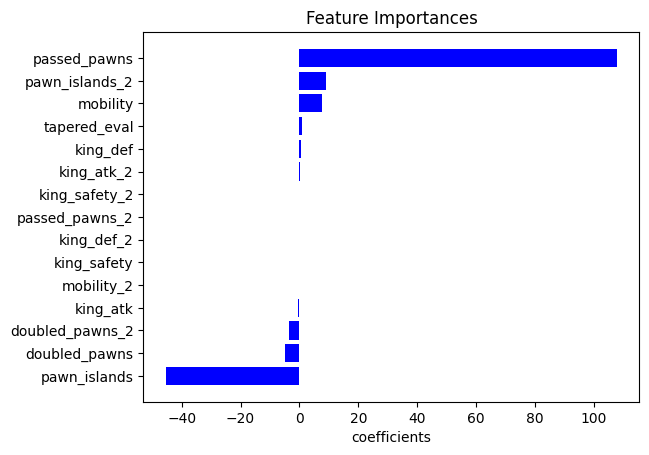

-45.315912416255394 pawn_islands
-4.755228650175023 doubled_pawns
-3.4921474077581753 doubled_pawns_2
-0.5933400295939361 king_atk
-0.13523609955554364 mobility_2
-0.0888245823055309 king_safety
-0.04983952722929273 king_def_2
0.002221983434129175 passed_pawns_2
0.012442590208750685 king_safety_2
0.29320628836098384 king_atk_2
0.5045154472882913 king_def
0.815558732332618 tapered_eval
7.763023308004178 mobility
8.908484395960459 pawn_islands_2
107.86326865845179 passed_pawns


In [120]:
features = X_train_reg.columns.values

importances = lin_reg.coef_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('coefficients')
plt.show()

for i in indices:
    print(importances[i], features[i])

224.13535316844775
225.2320265077373


In [88]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_reg, y_train_reg)

225.2320265077373

In [94]:
y_train_pred_rf = rf_reg.predict(X_train_reg)
y_test_pred_rf = rf_reg.predict(X_test_reg)

In [95]:
print(mean_absolute_error(y_train_reg, y_train_pred_rf))
print(mean_absolute_error(y_test_reg, y_test_pred_rf))

81.29723337742615
219.9255413218426


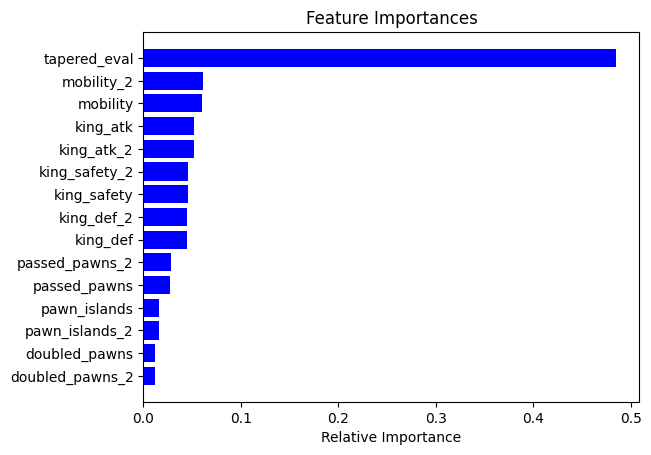

In [96]:
features = X_train_reg.columns.values
importances = rf_reg.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [97]:
reg_feat2 = reg_feat.drop(columns=['mobility', 'king_atk', 'king_def', 'king_safety', 'passed_pawns','doubled_pawns', 'pawn_islands'])

In [99]:
reg_feat1 = reg_feat.drop(columns=['mobility_2', 'king_atk_2', 'king_def_2', 'king_safety_2', 'passed_pawns_2','doubled_pawns_2', 'pawn_islands_2'])

In [110]:
X_train_reg2, X_test_reg2, y_train_reg2, y_test_reg2 = train_test_split(reg_feat2.drop(columns='sf_evaluation'), reg_feat2['sf_evaluation'], test_size=.25, random_state=42)


lin_reg2 = LinearRegression()

lin_reg2.fit(X_train_reg2, y_train_reg2)


y_train_pred_linreg2 = lin_reg2.predict(X_train_reg2)
y_test_pred_linreg2 = lin_reg2.predict(X_test_reg2)


print(mean_absolute_error(y_train_reg2, y_train_pred_linreg2))
print(mean_absolute_error(y_test_reg2, y_test_pred_linreg2))

222.00862606986274
223.11530799738995


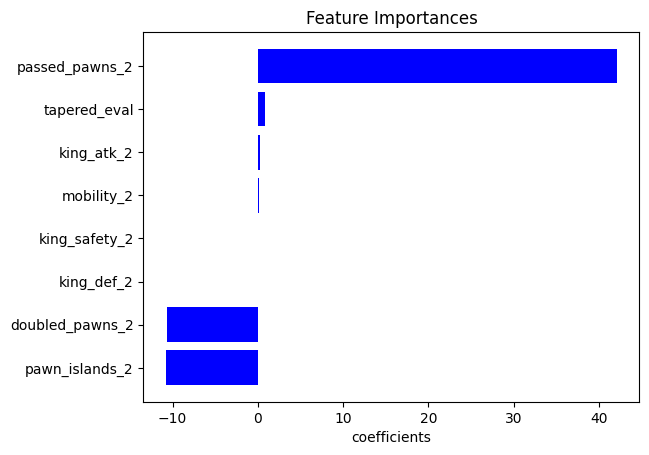

-10.772701322294408 pawn_islands_2
-10.711512833475288 doubled_pawns_2
-0.04315287035634648 king_def_2
0.02654653501154305 king_safety_2
0.0935836829524875 mobility_2
0.2841783339713082 king_atk_2
0.8827957450864872 tapered_eval
42.10625090754794 passed_pawns_2


In [113]:
importances = lin_reg2.coef_
indices = np.argsort(importances)

features = X_train_reg2.columns.values

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('coefficients')
plt.show()

for i in indices:
    print(importances[i], features[i])

In [114]:
X_train_reg1, X_test_reg1, y_train_reg1, y_test_reg1 = train_test_split(reg_feat1.drop(columns='sf_evaluation'), reg_feat1['sf_evaluation'], test_size=.25, random_state=42)


lin_reg1 = LinearRegression()

lin_reg1.fit(X_train_reg1, y_train_reg1)


y_train_pred_linreg1 = lin_reg1.predict(X_train_reg1)
y_test_pred_linreg1 = lin_reg1.predict(X_test_reg1)


print(mean_absolute_error(y_train_reg1, y_train_pred_linreg1))
print(mean_absolute_error(y_test_reg1, y_test_pred_linreg1))

224.6162593530813
225.91231337590818


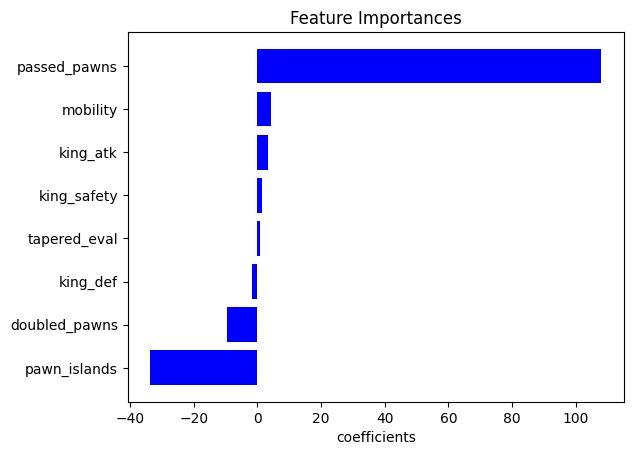

-33.69472986559315 pawn_islands
-9.71347239553862 doubled_pawns
-1.8654985113658027 king_def
0.8240029734736997 tapered_eval
1.5403317749572467 king_safety
3.4058302863230794 king_atk
4.258306244479642 mobility
108.01548906690225 passed_pawns


In [115]:
importances = lin_reg1.coef_
indices = np.argsort(importances)

features = X_train_reg1.columns.values

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('coefficients')
plt.show()

for i in indices:
    print(importances[i], features[i])

In [141]:
reg_feat3 = reg_feat.drop(columns=['mobility', 'king_atk_2', 'king_def_2', 'king_safety_2', 'king_def', 'king_atk', 'passed_pawns','doubled_pawns', 'pawn_islands'])

In [142]:
X_train_reg3, X_test_reg3, y_train_reg3, y_test_reg3 = train_test_split(reg_feat3.drop(columns='sf_evaluation'), reg_feat3['sf_evaluation'], test_size=.25, random_state=42)


lin_reg3 = LinearRegression()

lin_reg3.fit(X_train_reg3, y_train_reg3)


y_train_pred_linreg3 = lin_reg3.predict(X_train_reg3)
y_test_pred_linreg3 = lin_reg3.predict(X_test_reg3)


print(mean_absolute_error(y_train_reg3, y_train_pred_linreg3))
print(mean_absolute_error(y_test_reg3, y_test_pred_linreg3))

222.62111533006674
223.4368095107166


In [146]:
print(mean_squared_error(y_train_reg3, y_train_pred_linreg3))
print(mean_squared_error(y_test_reg3, y_test_pred_linreg3))

134314.05495854028
135519.95997161223


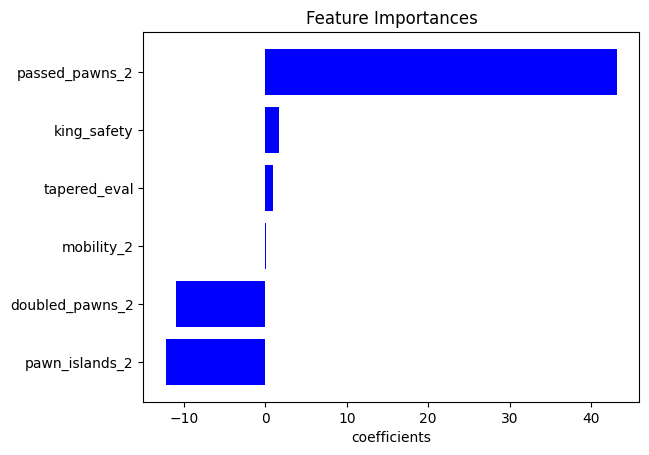

-12.211336047582556 pawn_islands_2
-10.989323012749525 doubled_pawns_2
0.11921912121128508 mobility_2
0.8957826182562153 tapered_eval
1.686172769493189 king_safety
43.17793328494146 passed_pawns_2


In [143]:
importances = lin_reg3.coef_
indices = np.argsort(importances)

features = X_train_reg3.columns.values

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('coefficients')
plt.show()

for i in indices:
    print(importances[i], features[i])

In [145]:
print(mean_absolute_error(reg_feat['sf_evaluation'], reg_feat['tapered_eval']))

224.6936949278846


In [147]:
print(mean_squared_error(reg_feat['sf_evaluation'], reg_feat['tapered_eval']))

141196.29036659334


In [150]:
pickle.dump(lin_reg3, open('lr_eval.pkl', 'wb'))

In [151]:
print(X_train_reg3.columns.values
    )

['tapered_eval' 'king_safety' 'mobility_2' 'pawn_islands_2'
 'doubled_pawns_2' 'passed_pawns_2']
